<a href="https://colab.research.google.com/github/Ananassio/Data-Minig-Lab/blob/main/Projekt/Projekt_Data_Minig_22_23_Marius_Zimmermann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Daten import


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
GCS_PATH = 'drive/MyDrive/DataMinig/'

In [14]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [15]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [16]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [17]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [18]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

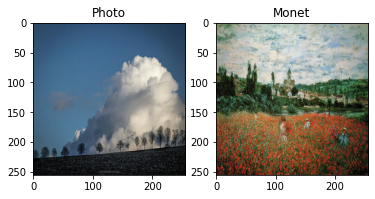

In [19]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [20]:
monet_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

# Modelgenerierung

Generator

In [21]:
def Generator():
  inputs = layers.input(shape=[256,256,3])

  # Center-crop images to 150x150
  l1 = CenterCrop(height=150, width=150)(inputs)
  # Rescale images to [0, 1]
  l2 = Rescaling(scale=1.0 / 255)(l1)

  # Apply some convolution and pooling layers
  l3 = layers.Conv2D(filters=64, kernel_size=(3, 3,3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l2)
  l4 = layers.MaxPooling2D(pool_size=(3, 3,3))(l3)
  l5 = layers.Conv2D(filters=128, kernel_size=(3, 3,3), activation="relu")(l4)
  l6 = layers.MaxPooling2D(pool_size=(3, 3))(l5)
  l7 = layers.Conv2D(filters=256, kernel_size=(3, 3,3), activation="relu")(l6)
  l8 = layers.MaxPooling2D(pool_size=(3, 3))(l7)
  l9 = layers.Conv2D(filters=512, kernel_size=(3, 3,3), activation="relu")(l8)


  # Apply global average pooling to get flat feature vectors
  l10 = layers.GlobalAveragePooling2D()(l9)

  # Add a dense classifier on top
  outputs = layers.Dense(num_classes, activation="softmax")(l10)


In [31]:
inputs = layers.Input(shape=[256,256,3])

  # Center-crop images to 150x150
l1 = CenterCrop(height=150, width=150)(inputs)
  # Rescale images to [0, 1]
l2 = Rescaling(scale=1.0 / 255)(l1)

  # Apply some convolution and pooling layers
l3 = layers.Conv2D(filters=64, kernel_size=(3, 3),kernel_initializer=tf.random_normal_initializer(0., 0.02) ,activation="relu")(l2)
l4 = layers.MaxPooling2D(pool_size=(3, 3))(l3)
l5 = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(l4)
l6 = layers.MaxPooling2D(pool_size=(3, 3))(l5)
l7 = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu")(l6)
l8 = layers.MaxPooling2D(pool_size=(3, 3))(l7)
l9 = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu")(l8)


  # Apply global average pooling to get flat feature vectors
l10 = layers.GlobalAveragePooling2D()(l9)

  # Add a dense classifier on top
outputs = layers.Dense(3, activation="tanh")(l10)

In [33]:


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 center_crop_3 (CenterCrop)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 128)       73856     
                                                           